![Fixel Algorithms](https://fixelalgorithms.co/images/CCExt.png)

# <center> Deep Learning Methods </center>
## <center> Lecture 10 - RNN </center>
### <center> Sentiment Analysis </center>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FixelAlgorithmsTeam/FixelCourses/blob/master/DeepLearningMethods/10_RNN/MainSentimentAnalysis.ipynb)

In [1]:
#-- Wide screen:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
#-- Auto reload:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy             as np
import matplotlib.pyplot as plt

import torch
import torch.nn    as nn
import torch.optim as optim
import torchsummary
import torchtext

from torchtext.data.utils import get_tokenizer
from torchtext.vocab      import Vocab
from torchtext.datasets   import IMDB

### Embedding layer:
Replace the integers $\left\{ 0,1,\dots,9\right\} $ to vectors in $\mathbb{R}^{5}$

In [4]:
oEmbedding = nn.Embedding(10, 5)
v          = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
oEmbedding(v)

tensor([[-0.8221, -1.1340, -1.1796, -0.5913, -0.5640],
        [ 1.0691,  0.6601, -1.5598, -1.4273,  0.6341],
        [ 0.3727, -0.7534, -1.6488, -1.2921,  2.0746],
        [ 0.2034, -1.3749,  1.1782, -2.4784,  0.9181],
        [ 0.4653,  1.5987, -0.0155, -0.4617, -0.4237],
        [ 0.7055, -0.6143,  0.7999,  1.6138,  0.3643],
        [-0.2880, -1.3430, -1.4173, -0.5826,  0.4581],
        [-1.0176, -0.0622, -0.4230,  1.1060, -2.4317],
        [-0.7340, -0.2430,  0.2804, -0.6148, -1.8122],
        [-1.4944, -0.7939,  0.2205,  0.9207,  0.7249]],
       grad_fn=<EmbeddingBackward>)

### Get the IMDB dataset:

In [5]:
dirPath             = '../../data'
oTokenizer          = get_tokenizer('basic_english')

trainIter, testIter = IMDB(root=dirPath)

lFullTrainSet = list(trainIter)
lFullTestSet  = list(testIter)

#### Filter long sequences:
Keep only sequences with less than `maxLength` words

In [6]:
def NumWords(line):
    return len(line.split())

maxLength = 100
lTrainSet = [(label, line) for (label, line) in lFullTrainSet if NumWords(line) < maxLength]
lTestSet  = [(label, line) for (label, line) in lFullTestSet  if NumWords(line) < maxLength]

In [7]:
len(lFullTrainSet), len(lFullTestSet), len(lTrainSet), len(lTestSet)

(25000, 25000, 2926, 3091)

#### Show some sentences:

In [8]:
import random

red   = '\x1b[31m'
green = '\x1b[32m'
end   = '\x1b[0m'

for _  in range(3):
    (label, line) = random.choice(lTrainSet)
    
    color = red if label == 'neg' else green
    print('=========================================================================================================')
    print('=========================================================================================================')
    print(color + line + end)
    print('--Tokenized:---------------------------')    
    print(oTokenizer(line))

Young Erendira and her tyrranical Grandmother provide for a great fantasy from the new world. This interpretation of Gabriel Garcia Marquez'"La incréible y triste historia da la cándida Eréndira,..." may not rub Marquez purists the right way eventhough The story stays intact and still carries the full force of the work. The strength of this film is in its acting especially Papas as the Grandmother. Marquez fans and Marquez novices alike will enjoy this movie for its real gritty brand of witt.
--Tokenized:---------------------------
['young', 'erendira', 'and', 'her', 'tyrranical', 'grandmother', 'provide', 'for', 'a', 'great', 'fantasy', 'from', 'the', 'new', 'world', '.', 'this', 'interpretation', 'of', 'gabriel', 'garcia', 'marquez', "'", 'la', 'incréible', 'y', 'triste', 'historia', 'da', 'la', 'cándida', 'eréndira', ',', '.', '.', '.', 'may', 'not', 'rub', 'marquez', 'purists', 'the', 'right', 'way', 'eventhough', 'the', 'story', 'stays', 'intact', 'and', 'still', 'carries', 'the',

### Build the vocabulary:
We keep only words that appear more than `min_freq` times.

In [9]:
from collections import Counter

oCounter  = Counter()
for ii, (label, line) in enumerate(lTrainSet):
    print(f'\r{len(lTrainSet) - ii:06}', end='')
    oCounter.update(oTokenizer(line))
    
oVocab = Vocab(oCounter, min_freq=10, specials=('<unk>', '<BOS>', '<EOS>', '<pad>'))
oVocab

000001

#### Using the vocabulary:

In [10]:
len(oVocab)

1831

In [11]:
oVocab['the'], oVocab['a'], oVocab['asfdlkasdjf']

(5, 7, 0)

In [12]:
oVocab.itos[4], oVocab.itos[8], oVocab.itos[0]

('.', 'and', '<unk>')

In [13]:
oVocab['have'], oVocab['a'], oVocab['!']

(31, 7, 19)

In [14]:
oVocab.freqs.most_common(20)

[('.', 15200),
 ('the', 10447),
 (',', 8499),
 ('a', 5859),
 ('and', 5457),
 ('of', 4715),
 ("'", 4473),
 ('it', 4416),
 ('this', 4352),
 ('is', 4272),
 ('i', 4159),
 ('to', 3947),
 ('movie', 2929),
 ('in', 2729),
 ('that', 2083),
 ('!', 2015),
 ('was', 2008),
 ('s', 1955),
 ('film', 1700),
 ('you', 1609)]

#### Text to sequence:

In [15]:
def TextTransform(line):
    return torch.tensor([oVocab['<BOS>']] + [oVocab[token] for token in oTokenizer(line)] + [oVocab['<EOS>']])

def LabelTransform(label):
    return 1 if label == 'pos' else 0

# Print out the output of text_transform
line = 'Hello World!'
print('Input :', line)
print('Output:', TextTransform(line))

Input : Hello World!
Output: tensor([  1,   0, 196,  19,   2])


In [16]:
from torch.utils.data   import DataLoader
from torch.nn.utils.rnn import pack_sequence

def CollateBatch(lBatch):
    Nb  = len(lBatch)
    vY  = torch.zeros(Nb)
    lX  = [None] * Nb
    for ii, (label, line) in enumerate(lBatch):
        vY[ii] = LabelTransform(label)
        lX[ii] = TextTransform (line)
    
    mPackX = pack_sequence(lX, enforce_sorted=False)

    return mPackX, vY

#### Remark
It is better to group lines with similar length together (as in `BucketIterator`).

In [17]:
batchSize = 64
oTrainDL  = DataLoader(lTrainSet, batch_size=batchSize,   shuffle=True,  collate_fn=CollateBatch)
oTestDL   = DataLoader(lTestSet,  batch_size=2*batchSize, shuffle=False, collate_fn=CollateBatch)

#### Define the RNN model:

In [18]:
from torch.nn.utils.rnn import PackedSequence

def PackedAs(mX, mPack):
    return PackedSequence(mX, mPack.batch_sizes, mPack.sorted_indices, mPack.unsorted_indices)

V = len(oVocab)
D = 64
H = 256
class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()
        
        self.oEmbedding = nn.Embedding(V, D)
        self.oRNN       = nn.RNN      (D, H, batch_first=True)
        self.oFC        = nn.Linear   (H, 1)
        
    def forward(self, mPackX):
                                              #-- mPackX.shape = (N*T,)
        mE     = self.oEmbedding(mPackX.data) #-- mE    .shape = (N*T, D)
        mPackE = PackedAs       (mE, mPackX)  #-- mPackE.shape = (N*T, D)
        _, mH = self.oRNN       (mPackE)      #-- mH    .shape = (1, N, H)
        mZ    = self.oFC        (mH[0])       #-- mZ    .shape = (N, 1)
        return mZ[:,0]
    

mPackX, vY = next(iter(oTrainDL))
RNN()(mPackX).shape

torch.Size([64])

In [19]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
Loss   = nn.BCEWithLogitsLoss()

In [20]:
from torch.optim                    import lr_scheduler
from DeepLearningFramework.Metric   import BinaryAcuuracy
from DeepLearningFramework.Training import TrainClassficationModel

nEpochs       = 100
nIter         = nEpochs * len(oTrainDL)
oModel        = RNN().to(DEVICE)
oOptim        = optim.Adam(oModel.parameters(), lr=5e-6, betas=(0.8, 0.9))
oScheduler    = lr_scheduler.OneCycleLR(oOptim, max_lr=5e-5, total_steps=nIter)
lHistory      = TrainClassficationModel(oModel, oTrainDL, oTestDL, Loss, BinaryAcuuracy, nEpochs, oOptim, oScheduler);

Epoch 000: | Train loss: 0.69084 | Val loss: 0.69198 | Train Metric: 0.5362 | Val Metric: 0.5315 | epoch time:  1.677 | <-- Checkpoint!
Epoch 001: | Train loss: 0.68969 | Val loss: 0.69121 | Train Metric: 0.5485 | Val Metric: 0.5377 | epoch time:  1.188 | <-- Checkpoint!
Epoch 002: | Train loss: 0.68877 | Val loss: 0.69052 | Train Metric: 0.5509 | Val Metric: 0.5409 | epoch time:  1.422 | <-- Checkpoint!
Epoch 003: | Train loss: 0.68773 | Val loss: 0.68977 | Train Metric: 0.5550 | Val Metric: 0.5400 | epoch time:  1.258 |
Epoch 004: | Train loss: 0.68673 | Val loss: 0.68903 | Train Metric: 0.5557 | Val Metric: 0.5393 | epoch time:  1.202 |
Epoch 005: | Train loss: 0.68573 | Val loss: 0.68808 | Train Metric: 0.5554 | Val Metric: 0.5396 | epoch time:  1.261 |
Epoch 006: | Train loss: 0.68464 | Val loss: 0.68721 | Train Metric: 0.5550 | Val Metric: 0.5403 | epoch time:  1.145 |
Epoch 007: | Train loss: 0.68351 | Val loss: 0.68620 | Train Metric: 0.5567 | Val Metric: 0.5419 | epoch time:  

Epoch 065: | Train loss: 0.45846 | Val loss: 0.60735 | Train Metric: 0.7963 | Val Metric: 0.7024 | epoch time:  1.129 | <-- Checkpoint!
Epoch 066: | Train loss: 0.45250 | Val loss: 0.62539 | Train Metric: 0.8008 | Val Metric: 0.6930 | epoch time:  1.129 |
Epoch 067: | Train loss: 0.45255 | Val loss: 0.60565 | Train Metric: 0.7980 | Val Metric: 0.6956 | epoch time:  1.121 |
Epoch 068: | Train loss: 0.45030 | Val loss: 0.61580 | Train Metric: 0.7977 | Val Metric: 0.6995 | epoch time:  1.148 |
Epoch 069: | Train loss: 0.44911 | Val loss: 0.61675 | Train Metric: 0.7943 | Val Metric: 0.7001 | epoch time:  1.191 |
Epoch 070: | Train loss: 0.44507 | Val loss: 0.61443 | Train Metric: 0.8025 | Val Metric: 0.6959 | epoch time:  1.146 |
Epoch 071: | Train loss: 0.44568 | Val loss: 0.60417 | Train Metric: 0.7987 | Val Metric: 0.7004 | epoch time:  1.113 |
Epoch 072: | Train loss: 0.44371 | Val loss: 0.61529 | Train Metric: 0.8011 | Val Metric: 0.7024 | epoch time:  1.117 |
Epoch 073: | Train loss:

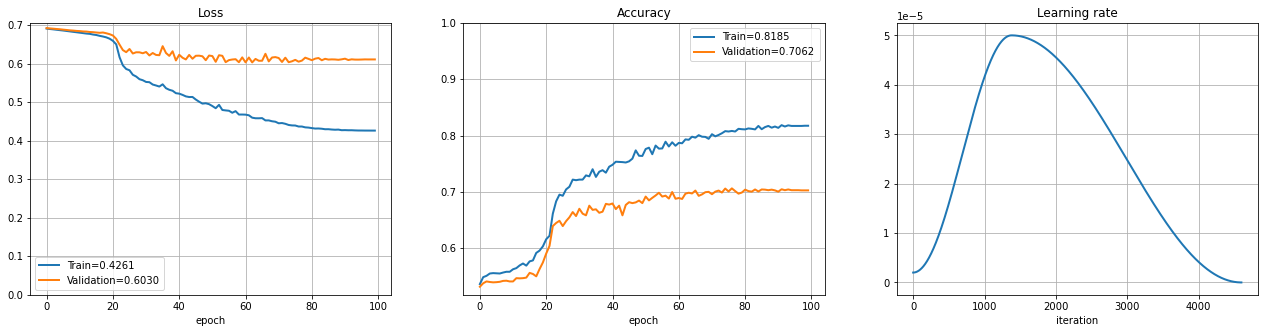

In [21]:
from DeepLearningFramework.Auxiliary import PlotHistory

PlotHistory(lHistory)